In [774]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from matplotlib.table import Table

data = pd.read_csv('train.csv')

In [775]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split the data into development set
data_dev = data[0:1000].T
# Extract the labels (Y) from the development set
Y_dev = data_dev[0]
# Extract the features (X) from the development set and normalize them
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

# Take the remaining samples after the development set for the training set
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

# Get the number of training examples
_, m_train = X_train.shape

In [776]:
def init_params():
    # Initialize the weights and biases for each layer randomly
    W1 = np.random.rand(80, 784) - 0.5  
    b1 = np.random.rand(80, 1) - 0.5  
    W2 = np.random.rand(80, 80) - 0.5  
    b2 = np.random.rand(80, 1) - 0.5  
    W3 = np.random.rand(10, 80) - 0.5  
    b3 = np.random.rand(10, 1) - 0.5 
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3  
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return np.where(Z > 0, 1, 0)

def one_hot(Y):
    # Convert class labels to one-hot encoded vectors
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, max_grad_norm, lambd):
    m = X.shape[1]
    one_hot_Y = one_hot(Y)
    
    # Compute gradients for the third hidden layer
    dZ3 = A3 - one_hot_Y
    dW3 = np.dot(dZ3, A2.T) / m + (lambd / m) * W3
    db3 = np.mean(dZ3, axis=1, keepdims=True)
    
    # Backpropagate gradients to the second hidden layer
    dZ2 = np.dot(W3.T, dZ3) * ReLU_deriv(Z2)
    dW2 = np.dot(dZ2, A1.T) / m + (lambd / m) * W2
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    
    # Backpropagate gradients to the first hidden layer
    dZ1 = np.dot(W2.T, dZ2) * ReLU_deriv(Z1)
    dW1 = np.dot(dZ1, X.T) / m + (lambd / m) * W1
    db1 = np.mean(dZ1, axis=1, keepdims=True)

    # Apply gradient clipping if needed
    grad_norm = np.linalg.norm(dW3)
    if grad_norm > max_grad_norm:
        dW3 *= max_grad_norm / grad_norm
    grad_norm = np.linalg.norm(dW2)
    if grad_norm > max_grad_norm:
        dW2 *= max_grad_norm / grad_norm
    grad_norm = np.linalg.norm(dW1)
    if grad_norm > max_grad_norm:
        dW1 *= max_grad_norm / grad_norm
    
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha, beta1, beta2, epsilon):
    # Initialize velocity and squared gradient variables
    v_dW1 = np.zeros_like(dW1)
    v_db1 = np.zeros_like(db1)
    v_dW2 = np.zeros_like(dW2)
    v_db2 = np.zeros_like(db2)
    v_dW3 = np.zeros_like(dW3)
    v_db3 = np.zeros_like(db3)
    
    s_dW1 = np.zeros_like(dW1)
    s_db1 = np.zeros_like(db1)
    s_dW2 = np.zeros_like(dW2)
    s_db2 = np.zeros_like(db2)
    s_dW3 = np.zeros_like(dW3)
    s_db3 = np.zeros_like(db3)
    
    # Update velocity and squared gradient variables using Adam optimization
    v_dW1 = beta1 * v_dW1 + (1 - beta1) * dW1
    v_db1 = beta1 * v_db1 + (1 - beta1) * db1
    v_dW2 = beta1 * v_dW2 + (1 - beta1) * dW2
    v_db2 = beta1 * v_db2 + (1 - beta1) * db2
    v_dW3 = beta1 * v_dW3 + (1 - beta1) * dW3
    v_db3 = beta1 * v_db3 + (1 - beta1) * db3
    
    s_dW1 = beta2 * s_dW1 + (1 - beta2) * dW1**2
    s_db1 = beta2 * s_db1 + (1 - beta2) * db1**2
    s_dW2 = beta2 * s_dW2 + (1 - beta2) * dW2**2
    s_db2 = beta2 * s_db2 + (1 - beta2) * db2**2
    s_dW3 = beta2 * s_dW3 + (1 - beta2) * dW3**2
    s_db3 = beta2 * s_db3 + (1 - beta2) * db3**2
    
    # Correct for bias in the first and second moments estimates
    v_dW1_corrected = v_dW1 / (1 - beta1)
    v_db1_corrected = v_db1 / (1 - beta1)
    v_dW2_corrected = v_dW2 / (1 - beta1)
    v_db2_corrected = v_db2 / (1 - beta1)
    v_dW3_corrected = v_dW3 / (1 - beta1)
    v_db3_corrected = v_db3 / (1 - beta1)
    
    s_dW1_corrected = s_dW1 / (1 - beta2)
    s_db1_corrected = s_db1 / (1 - beta2)
    s_dW2_corrected = s_dW2 / (1 - beta2)
    s_db2_corrected = s_db2 / (1 - beta2)
    s_dW3_corrected = s_dW3 / (1 - beta2)
    s_db3_corrected = s_db3 / (1 - beta2)
    
    # Update the parameters using Adam optimizer
    W1 -= alpha * v_dW1_corrected / (np.sqrt(s_dW1_corrected) + epsilon)
    b1 -= alpha * v_db1_corrected / (np.sqrt(s_db1_corrected) + epsilon)
    W2 -= alpha * v_dW2_corrected / (np.sqrt(s_dW2_corrected) + epsilon)
    b2 -= alpha * v_db2_corrected / (np.sqrt(s_db2_corrected) + epsilon)
    W3 -= alpha * v_dW3_corrected / (np.sqrt(s_dW3_corrected) + epsilon)
    b3 -= alpha * v_db3_corrected / (np.sqrt(s_db3_corrected) + epsilon)

    return W1, b1, W2, b2, W3, b3

In [777]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    # Calculate the number of correct predictions and get the accuracy by dividing the number of correct predictions by the total number of predictions
    num_correct = np.sum(predictions == Y)
    accuracy = num_correct / Y.size
    return accuracy

def make_predictions(X, W1, b1, W2, b2, W3, b3):
    # Get the predictions by finding the index of the maximum value along each column of A3
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def clip_gradients(dW1, db1, dW2, db2, dW3, db3, max_grad_norm):
    # Clip the gradients by scaling them down based on the ratio of the maximum gradient norm to the gradient norm
    grad_norm = np.sqrt(np.sum(np.square(dW1)) + np.sum(np.square(db1)) + np.sum(np.square(dW2)) + np.sum(np.square(db2)) + np.sum(np.square(dW3)) + np.sum(np.square(db3)))
    if grad_norm > max_grad_norm:
        dW1 = dW1 * max_grad_norm / grad_norm
        db1 = db1 * max_grad_norm / grad_norm
        dW2 = dW2 * max_grad_norm / grad_norm
        db2 = db2 * max_grad_norm / grad_norm
        dW3 = dW3 * max_grad_norm / grad_norm
        db3 = db3 * max_grad_norm / grad_norm
    return dW1, db1, dW2, db2, dW3, db3

In [778]:
def plot_accuracy_iterations(num_iterations, train_accuracy, dev_accuracy):
    plt.plot(range(num_iterations), train_accuracy[:num_iterations], label='Train Accuracy')
    plt.plot(range(num_iterations), dev_accuracy[:num_iterations], label='Dev Accuracy')
    plt.xlabel('Iterations (x50)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Iterations')
    plt.legend()
    plt.show()
    
def plot_gradient_norm_iterations(num_iterations, grad_norms):
    plt.plot(range(num_iterations + 1), grad_norms)
    plt.xlabel('Iterations (x50)')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm vs. Iterations')
    plt.show()

In [779]:
def gradient_descent(X, Y, alpha, beta1, beta2, epsilon, max_grad_norm, lambd, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    best_train_acc = 0
    best_dev_acc = 0
    p_train_accuracy = []
    p_dev_accuracy = []
    p_grad_norms = []
    
    for i in range(iterations + 1):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, max_grad_norm, lambd)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha, beta1, beta2, epsilon)
        
        if i % 50 == 0:
            train_predictions = make_predictions(X_train, W1, b1, W2, b2, W3, b3)
            dev_predictions = make_predictions(X_dev, W1, b1, W2, b2, W3, b3)
            train_acc = get_accuracy(train_predictions, Y)
            dev_acc = get_accuracy(dev_predictions, Y_dev)
            
            # Append current accuracy values for Accuracy vs. Iterations graph
            p_train_accuracy.append(train_acc)
            p_dev_accuracy.append(dev_acc)
            # Calculate and append gradient norm for Gradient Norm vs. Iterations graph
            dW1, db1, dW2, db2, dW3, db3 = clip_gradients(dW1, db1, dW2, db2, dW3, db3, max_grad_norm)
            p_grad_norms.append(np.sqrt(np.sum(np.square(dW1)) + np.sum(np.square(db1)) + np.sum(np.square(dW2)) + np.sum(np.square(db2)) + np.sum(np.square(dW3)) + np.sum(np.square(db3))))
             
            print(f"Iteration: {i}")
            # Print training accuracy with color coding based on improvement
            if train_acc < best_train_acc:
                print(f"Train accuracy: {train_acc} \033[31m-{(best_train_acc - train_acc):.5f}\033[0m")
            elif train_acc > best_train_acc:
                print(f"Train accuracy: {train_acc} \033[32m+{(train_acc - best_train_acc):.5f}\033[0m")
            else:
                print(f"Train accuracy: {train_acc}")
                
            # Print dev accuracy with color coding based on improvement and overfitting indication
            if dev_acc < best_dev_acc:
                print(f"Dev accuracy: {dev_acc} \033[31m-{(best_dev_acc - dev_acc):.5f}\033[0m")
                print("OVERFITTING")
            elif dev_acc > best_dev_acc:
                print(f"Dev accuracy: {dev_acc} \033[32m+{(dev_acc - best_dev_acc):.5f}\033[0m")
            else:
                print(f"Dev accuracy: {dev_acc}")
                
            best_train_acc = max(best_train_acc, train_acc)
            best_dev_acc = max(best_dev_acc, dev_acc)
            print("\n")
           
    num_iterations = iterations // 50
    plot_accuracy_iterations(num_iterations, p_train_accuracy, p_dev_accuracy)
    plot_gradient_norm_iterations(num_iterations, p_grad_norms)
    return W1, b1, W2, b2, W3, b3

Iteration: 0
Train accuracy: 0.09617073170731708 +0.09617
Dev accuracy: 0.081 +0.08100


Iteration: 50
Train accuracy: 0.6403658536585366 +0.54420
Dev accuracy: 0.608 +0.52700


Iteration: 100
Train accuracy: 0.8672195121951219 +0.22685
Dev accuracy: 0.861 +0.25300


Iteration: 150
Train accuracy: 0.9182439024390244 +0.05102
Dev accuracy: 0.915 +0.05400


Iteration: 200
Train accuracy: 0.9412682926829268 +0.02302
Dev accuracy: 0.933 +0.01800


Iteration: 250
Train accuracy: 0.9555853658536585 +0.01432
Dev accuracy: 0.935 +0.00200


Iteration: 300
Train accuracy: 0.965609756097561 +0.01002
Dev accuracy: 0.941 +0.00600


Iteration: 350
Train accuracy: 0.9723414634146341 +0.00673
Dev accuracy: 0.944 +0.00300


Iteration: 400
Train accuracy: 0.9771219512195122 +0.00478
Dev accuracy: 0.944


Iteration: 450
Train accuracy: 0.980780487804878 +0.00366
Dev accuracy: 0.945 +0.00100


Iteration: 500
Train accuracy: 0.9839512195121951 +0.00317
Dev accuracy: 0.945




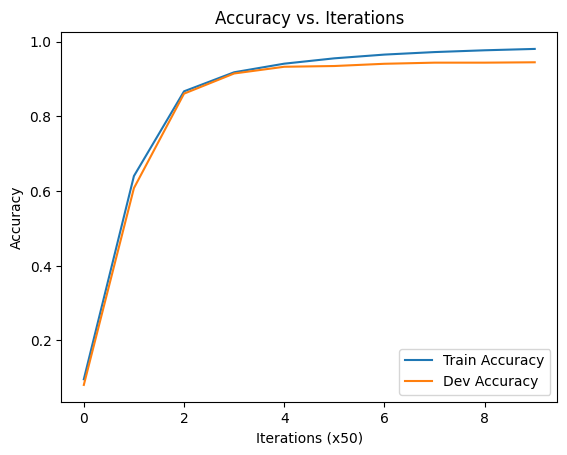

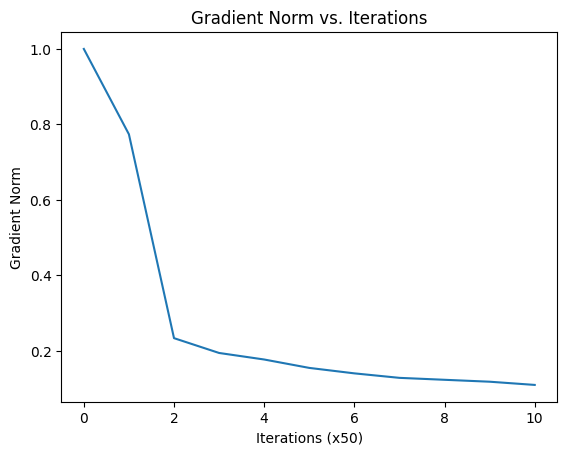

In [780]:
W1, b1, W2, b2, W3, b3 = gradient_descent(
    X_train,            # Training data
    Y_train,            # Training labels
    0.0005,             # Learning rate
    0.9,                # Exponential decay rate for the first moment estimates (beta1)
    0.999,              # Exponential decay rate for the second moment estimates (beta2)
    1e-8,               # Small value to avoid division by zero (epsilon)
    1,                  # Maximum gradient norm for gradient clipping
    0.1,                # Regularization parameter (lambda)
    500                 # Number of iterations
)

In [783]:
def create_table(num_samples, indexes):
    # Calculate the number of rows and columns needed for the table
    num_rows = (num_samples + 2) // 3
    num_cols = min(num_samples, 7)

    if num_rows == 1:
        fig, ax = plt.subplots(1, num_cols, figsize=(10, 10))
    else:
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    
    for i, index in enumerate(indexes):
        row = i // num_cols
        col = i % num_cols

        current_image = X_train[:, index]
        prediction = make_predictions(X_train, W1, b1, W2, b2, W3, b3)[index]
        label = Y_train[index]
        
        # Plot the image in the corresponding subplot
        image_description = f"Index: {index}\nPrediction: {prediction}\nLabel: {label}"
        if num_rows > 1:
            ax[row, col].imshow(current_image.reshape((28, 28)) * 255, cmap='gray')
            ax[row, col].axis('off')
            ax[row, col].set_title(image_description)
        else:
            if num_cols > 1:
                ax[col].imshow(current_image.reshape((28, 28)) * 255, cmap='gray')
                ax[col].axis('off')
                ax[col].set_title(image_description)
            else:
                ax.imshow(current_image.reshape((28, 28)) * 255, cmap='gray')
                ax.axis('off')
                ax.set_title(image_description)

    # Remove empty subplots if any
    for i in range(num_samples, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        if num_rows > 1:
            fig.delaxes(ax[row, col])
        else:
            if num_cols > 1:
                fig.delaxes(ax[col])
            else:
                fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

def display_predictions(correct=True, num_samples=7):
    indexes = []
    samples = 0
    index = random.randint(0, 10000)
    while samples < num_samples:
        prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
        label = Y_train[index]
        if (correct and prediction == label) or (not correct and prediction != label):
            indexes.append(index)
            samples += 1
        index = random.randint(0, 10000)
    create_table(num_samples, indexes)
    
def display_predictions_random(num_samples=4):
    indexes = []
    samples = 0
    index = random.randint(0, 10000)
    while samples < num_samples:
        prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
        label = Y_train[index]
        indexes.append(index)
        samples += 1
        index = random.randint(0, 10000)
    create_table(num_samples, indexes)

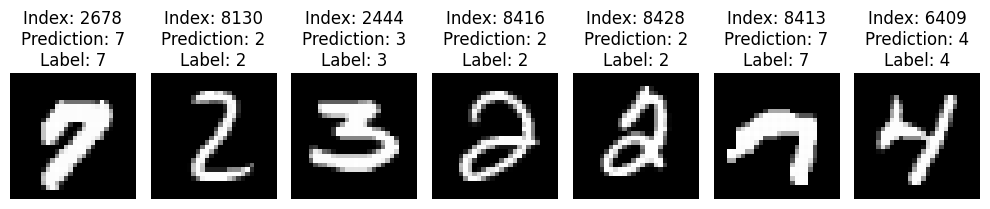

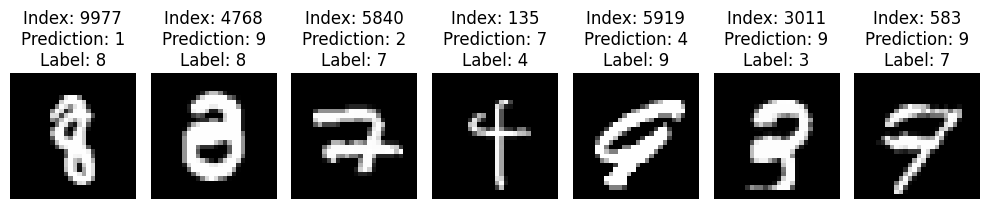

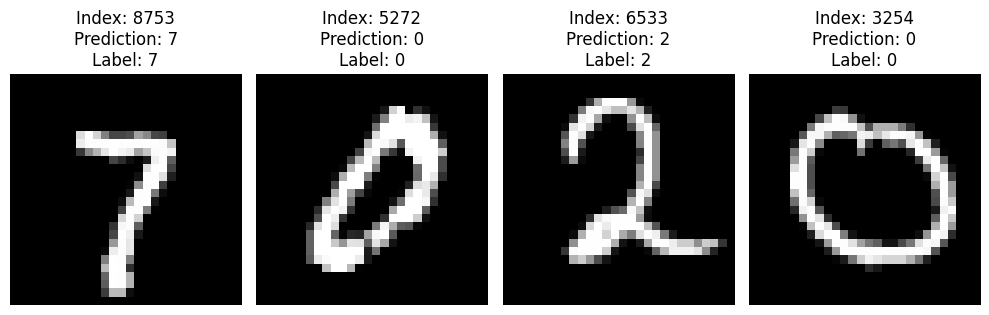

In [785]:
# Display predictions of correctly classified samples
display_predictions()
# Display predictions of incorrectly classified samples
display_predictions(False)
# Display random predictions
display_predictions_random()